In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

Loading the data

In [27]:
print("laoding the data...")
df=pd.read_csv('hospital_ds.csv')
print(f"Dataset Shape: {df.shape}")

laoding the data...
Dataset Shape: (30000, 12)


Preprocessing the data

In [28]:
#spliting the blood pressure
df['systolic'] = df['blood_pressure'].str.split('/').str[0].astype(int)
df['diastolic'] = df['blood_pressure'].str.split('/').str[1].astype(int)

In [29]:
#labeling the categorial columns
le_dict = {}
cat_cols = ['gender', 'diabetes', 'hypertension', 'discharge_destination', 'readmitted_30_days']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

Performing EDA


Generating correlation matrix...


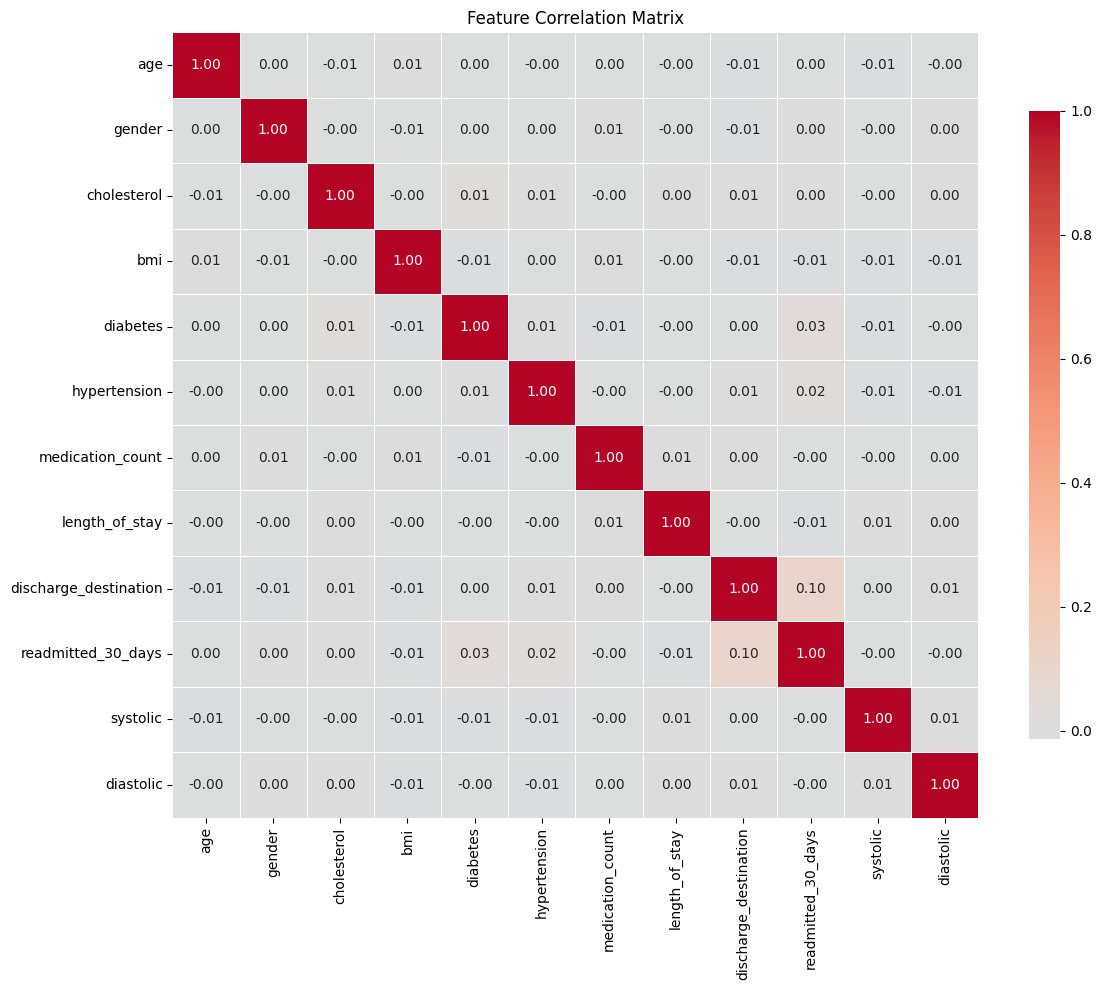

In [30]:
print("\nGenerating correlation matrix...")
df_numeric = df.drop(['patient_id', 'blood_pressure'], axis=1, errors='ignore')
df_numeric = df_numeric.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
corr = df_numeric.corr()
#getting the heatmap for better understanding of the dataset
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('correlation.png', dpi=300, bbox_inches='tight')
plt.show()

Preparing the features and target 

In [31]:
X = df.drop(['patient_id', 'blood_pressure', 'readmitted_30_days'], axis=1)
y = df['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Training the model

In [32]:
print("\nTraining Random Forest...")
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


Training Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


evaluating the model
for Accuracy and Classification report 

In [33]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8775

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      5265
           1       0.00      0.00      0.00       735

    accuracy                           0.88      6000
   macro avg       0.44      0.50      0.47      6000
weighted avg       0.77      0.88      0.82      6000



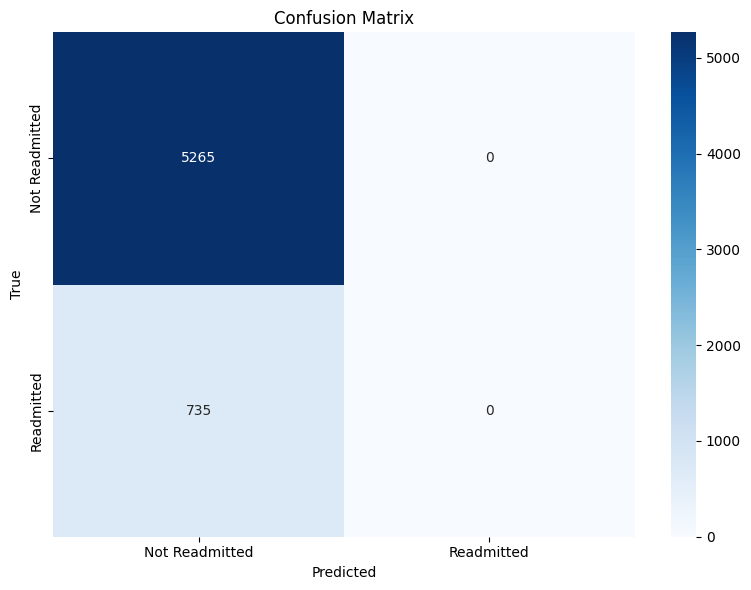

In [34]:
#to get the confusion matrix(heatmap)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Visualization on the tree (trained tree)

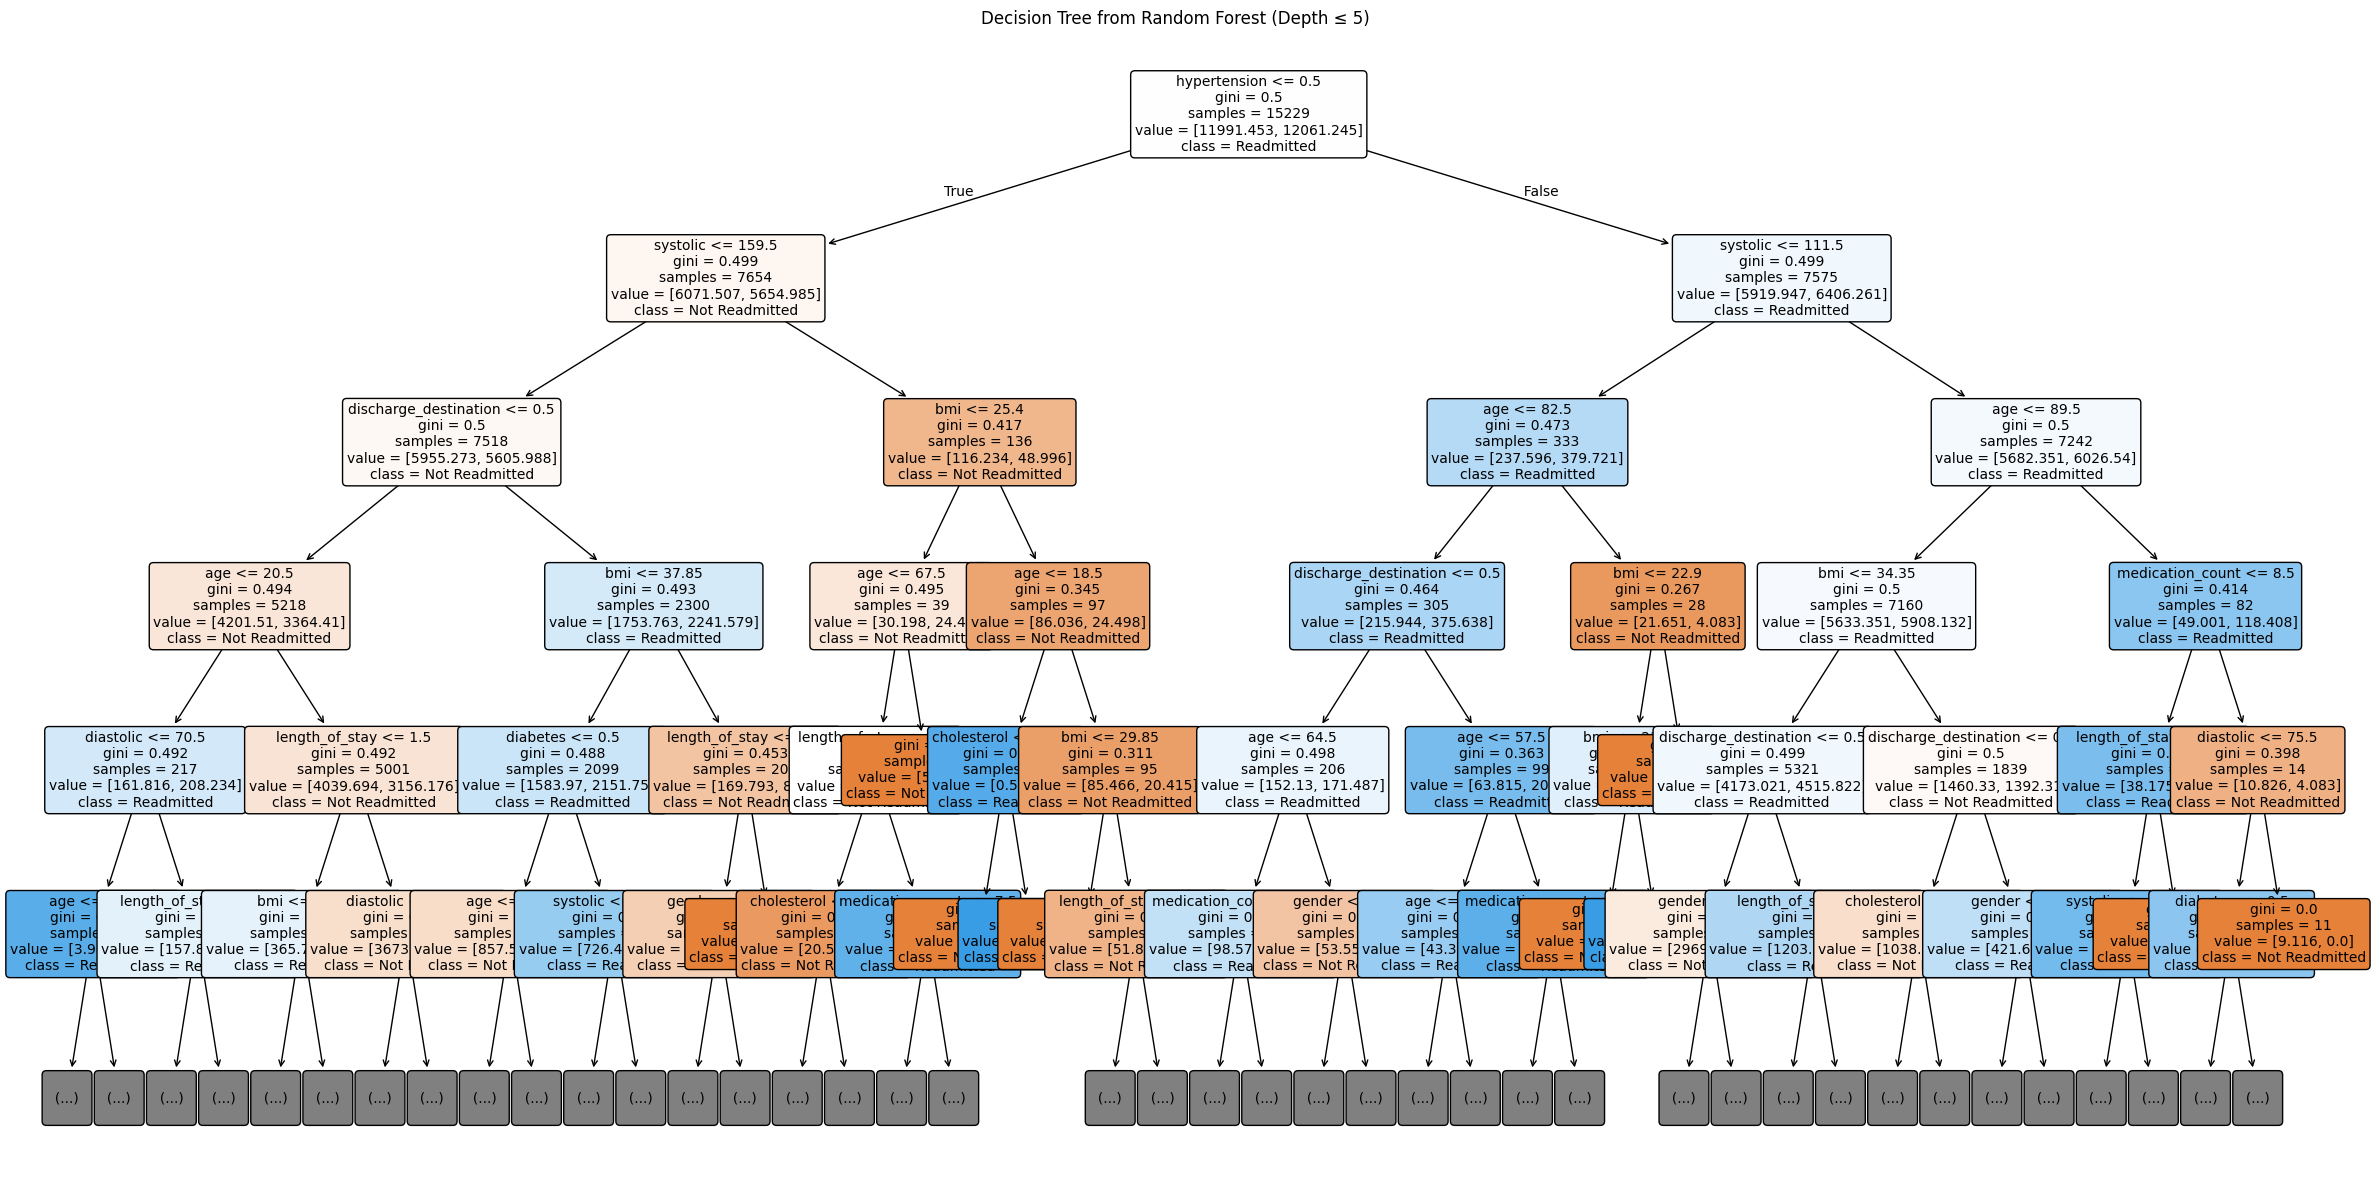

In [40]:
plt.figure(figsize=(24,12))
tree = model.estimators_[0]
plot_tree(tree,
          feature_names=X.columns,
          class_names=['Not Readmitted', 'Readmitted'],
          filled=True, rounded=True, fontsize=10, max_depth=5)
plt.title("Decision Tree from Random Forest (Depth ≤ 5)")
plt.tight_layout()
plt.savefig('RF_Visualisation_tree.png', dpi=300, bbox_inches='tight')
plt.show()

saving the model an encoders

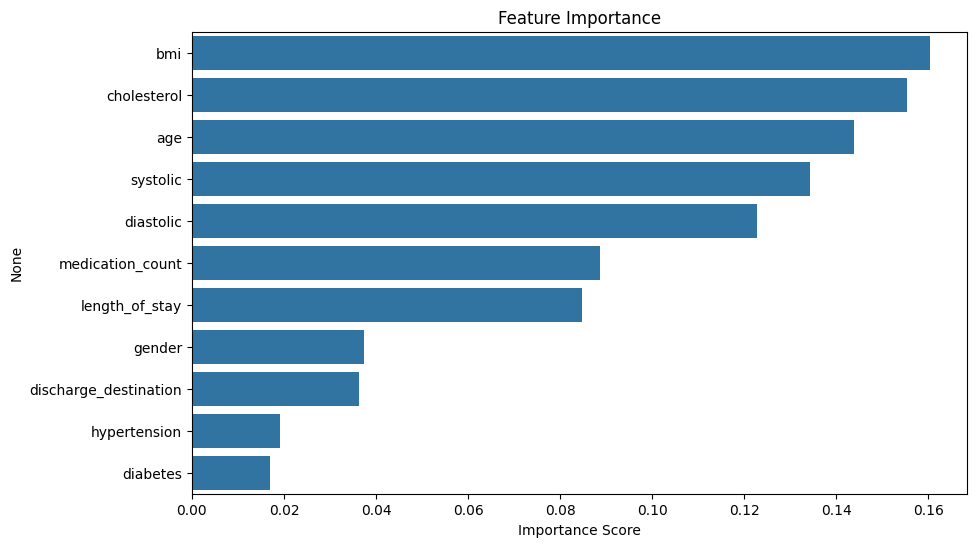

Model and label encoders saved successfully!


In [36]:
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.savefig('Feature_importance_bargraph.png', dpi=300, bbox_inches='tight')
plt.show()

joblib.dump(model, 'rf_model.pkl')
joblib.dump(le_dict, 'label_encoders.pkl')
print("Model and label encoders saved successfully!")